In [1]:
%pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 26.5 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import numpy as np

In [3]:
import requests

url = "https://www.dropbox.com/scl/fi/x2eh2yil56rgu5id1fwbm/cnn_data1.csv?rlkey=7bltxkitlwdnuirw08r2ysuv4&st=wmmcg5by&dl=1"
response = requests.get(url)

# Save the file locally
with open('cnn_data1.csv', 'wb') as file:
    file.write(response.content)

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_data_hist(df):
    # Define figure size and layout for subplots
    fig, axs = plt.subplots(3, 5, figsize=(15, 15), dpi=80)

    # List of columns to plot histograms for
    columns = ['Activation Function', 'Total Activations', 'Total Parameters', 'Batch Size',
               'Total_Activations_Batch_Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count',
               'AdaptiveAvgPool2d Count', 'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
               'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)']

    # Loop over the axes and columns to create histograms
    for ax, col in zip(axs.ravel(), columns):
        if pd.api.types.is_numeric_dtype(df[col]):
            ax.hist(df[col], bins=200)
            ax.set_xlabel(col)
            ax.set_ylabel('count')
        else:
            print(f"Skipping non-numeric column: {col}")

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()


0       39517
1       36831
2        6293
3        6475
4        2779
        ...  
8995    40123
8996    38637
8997    26097
8998    39617
8999     4321
Name: Max GPU Memory (MiB), Length: 9000, dtype: int64
#datapoints:  9000
0       39517
1       42000
2        6293
3        6475
4        2779
        ...  
8995    42000
8996    42000
8997    26097
8998    42000
8999     4321
Name: Max GPU Memory (MiB), Length: 9000, dtype: int64
#datapoints:  9000
Index(['Activation Function', 'Total Activations', 'Total Parameters',
       'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count',
       'BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
       'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)',
       'Max GPU Memory (MiB)'],
      dtype='object')
Activation Function | max :  Tanh | min:  ELU
Total Activations | max :  5317481490 | min:  22265
Total Parameters | max :  329307377 | min:  704

<Figure size 10000x800 with 0 Axes>

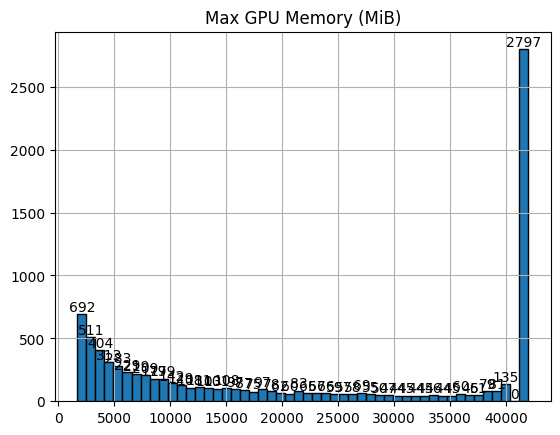

Skipping non-numeric column: Activation Function


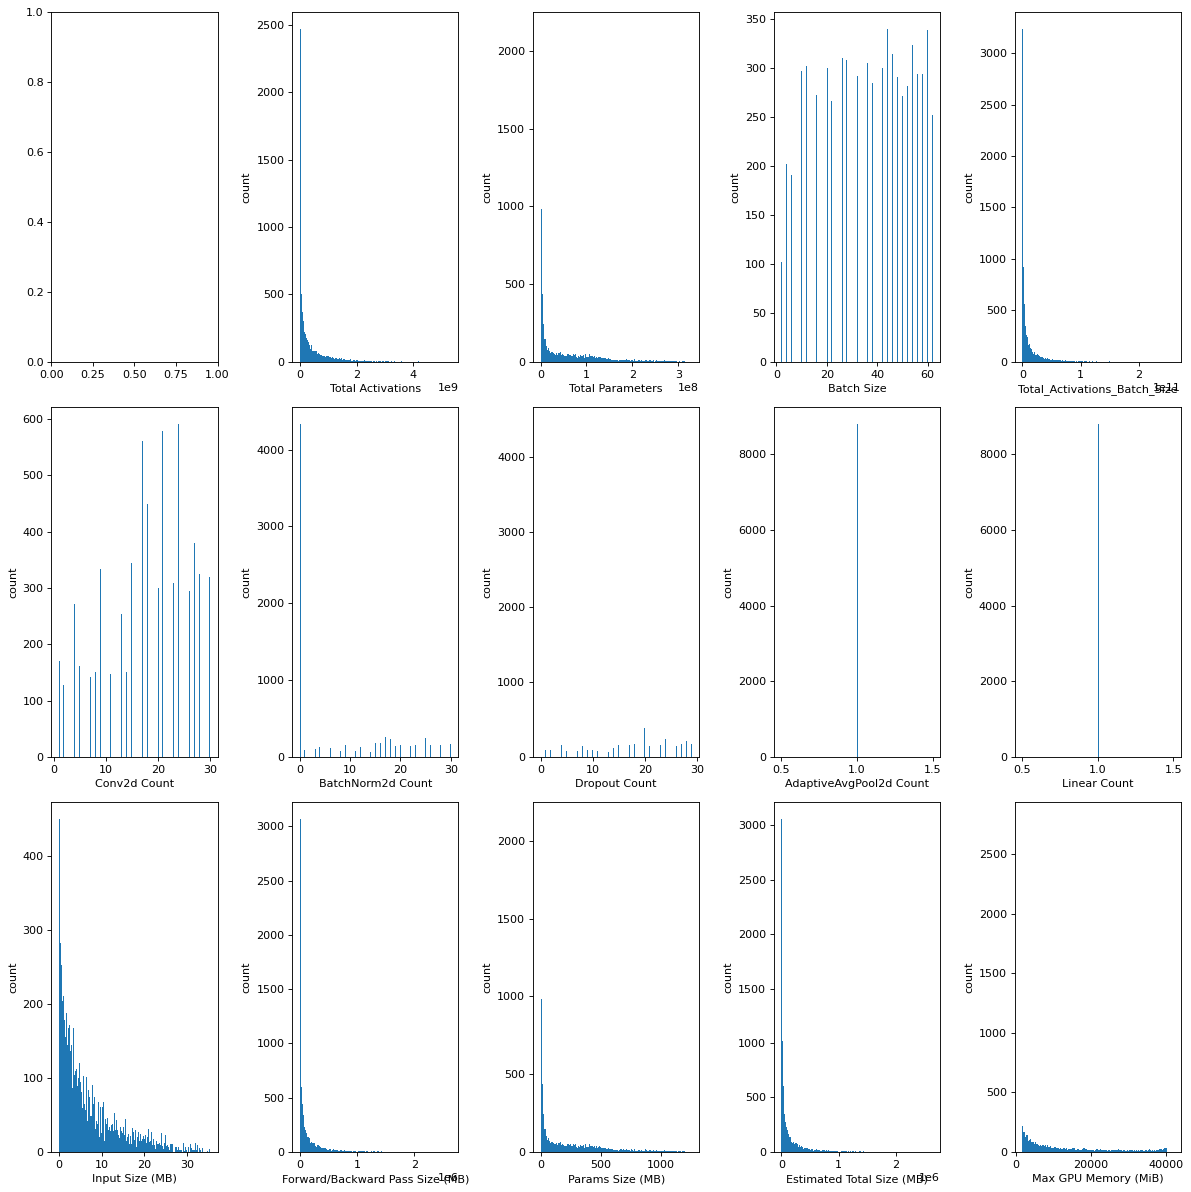

In [5]:
csv_file_path = "cnn_data1.csv"  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)


print(df['Max GPU Memory (MiB)'])
print("#datapoints: ", len(df))
# print(df.columns)

df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']

# training tasks crashed because of OOM, should be put aside (filter out)
# df = df.loc[df['Status'] != 'OOM_CRASH']

df.loc[df['Status'] == 'OOM_CRASH', 'Max GPU Memory (MiB)'] = 42000


print(df['Max GPU Memory (MiB)'])

print("#datapoints: ", len(df))


# dropping lines that they have NaN values as they will cause error in the next steps
# df = df.dropna()

df = df.dropna(subset=['Activation Function'])


# df = df[df['BatchNorm2d Count'] == 0]
# df = df[df['Dropout Count'] == 0]


df = df[['Activation Function', 'Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count', 'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)']]

# print(df.columns)

# Map the existing columns to your desired column structure

# df = df.rename(columns={
#     'Max GPU Memory (MiB)': 'real_memory_usage',
#     'Conv2d Count': 'conv2d_layers',
#     'Activation Function': 'activation_function',
#     'Total_Activations_Batch_Size': 'total_activation_mul_batch_size',
#     'Batch Size': 'batch_size',
#     'Total Parameters': 'all_parameters',
#     'Total Activations': 'all_activations',
#     'Activations-Params': 'params_activation_list',
#     'BatchNorm2d Count': 'batch_norm2d_layer',
#     'Dropout Count': 'dropout_layers',
#     'Linear Count': 'linear_layers',
#     'AdaptiveAvgPool2d Count': 'adaptive_avg_pool2d_layers'
# })

print(df.columns)


columns_to_analyze = ['Activation Function', 'Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count', 'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)']
for col in columns_to_analyze:
    if col == 'activation_function':
      continue
    print(f'{col} | max : ', df[col].max(), '| min: ', df[col].min())
print('len dataset: ', len(df))

# print(df.dtypes)


print("#datapoints: ", len(df))


# Plotting the histogram of 'Max GPU Memory (MiB)' with increased figure size and labeled bins
plt.figure(figsize=(100, 8))  # Increase the size of the figure
ax = df[['Max GPU Memory (MiB)']].hist(bins=50, edgecolor='black')

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

plot_data_hist(df)

# Drawing data for getting insight into it

                                     Activations-Params
0     [('conv2d', 183956976, 2744), ('GELU', 1839569...
1     [('conv2d', 44835280, 700), ('batchnorm2d', 44...
2     [('conv2d', 33323400, 3388), ('ELU', 33323400,...
3     [('conv2d', 18688000, 2044), ('batchnorm2d', 1...
4     [('conv2d', 2230272, 640), ('batchnorm2d', 223...
...                                                 ...
8995  [('conv2d', 78314600, 9268), ('batchnorm2d', 7...
8996  [('conv2d', 179144784, 12152), ('ELU', 1791447...
8997  [('conv2d', 25423200, 8988), ('PReLU', 2542320...
8998  [('conv2d', 128597760, 12096), ('batchnorm2d',...
8999  [('conv2d', 6967296, 896), ('batchnorm2d', 696...

[9000 rows x 1 columns]


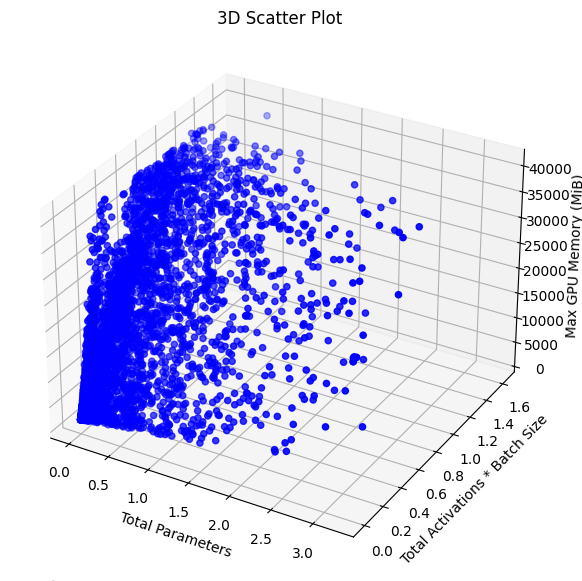

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

csv_file_path = "cnn_data1.csv"  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df_tmp = pd.read_csv(csv_file_path)


print(df_tmp[['Activations-Params']])
df_tmp = df_tmp.loc[df_tmp['Status'] != 'OOM_CRASH']

df_tmp = df_tmp.dropna()

# print(df_tmp)

df_tmp = df_tmp[['Activation Function', 'Total Activations', 'Total Parameters', 'Batch Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count', 'Linear Count', 'Max GPU Memory (MiB)']]


# Prepare data for the 3D plot
x = df_tmp['Total Parameters']
y = df_tmp['Total Activations'] * df_tmp['Batch Size']
z = df_tmp['Max GPU Memory (MiB)']

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='b', marker='o')

# Labels
ax.set_xlabel('Total Parameters')
ax.set_ylabel('Total Activations * Batch Size')
ax.set_zlabel('Max GPU Memory (MiB)')

plt.title('3D Scatter Plot')
plt.show()

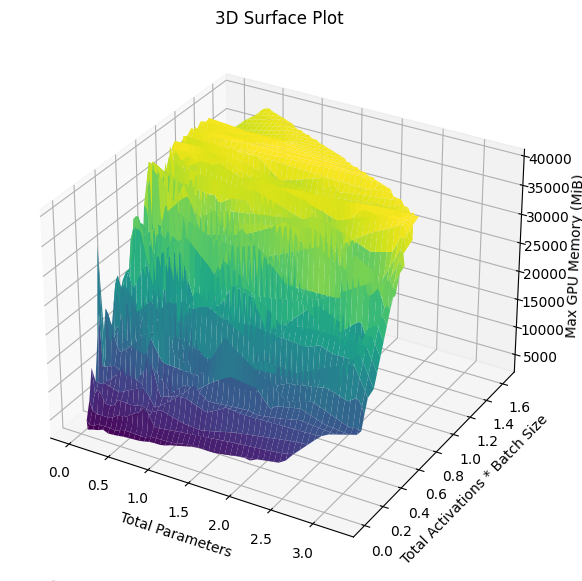

In [7]:
from scipy.interpolate import griddata

# Prepare data for the 3D surface plot
x = df_tmp['Total Parameters']
y = df_tmp['Total Activations'] * df_tmp['Batch Size']
z = df_tmp['Max GPU Memory (MiB)']

# Create a grid to interpolate data
xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
zi = griddata((x, y), z, (xi, yi), method='linear')

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xi, yi, zi, cmap='viridis')

# Labels
ax.set_xlabel('Total Parameters')
ax.set_ylabel('Total Activations * Batch Size')
ax.set_zlabel('Max GPU Memory (MiB)')

plt.title('3D Surface Plot')
plt.show()


     Activation Function  Total Activations  Total Parameters  Batch Size  \
22             LeakyReLU           22255293           3669944           2   
47             LeakyReLU           82535020           5336091          60   
64             LeakyReLU           18191698            175902           2   
100            LeakyReLU          978806394         118426836           2   
229            LeakyReLU          292644526           5007968          18   
...                  ...                ...               ...         ...   
8369           LeakyReLU          165425400          33831690          36   
8451           LeakyReLU           45754055          31030564          56   
8719           LeakyReLU            2378857            765324          32   
8901           LeakyReLU          126531690         261894712          18   
8949           LeakyReLU           17501569           1258940          26   

      Conv2d Count  BatchNorm2d Count  Dropout Count  AdaptiveAvgPool2d Cou

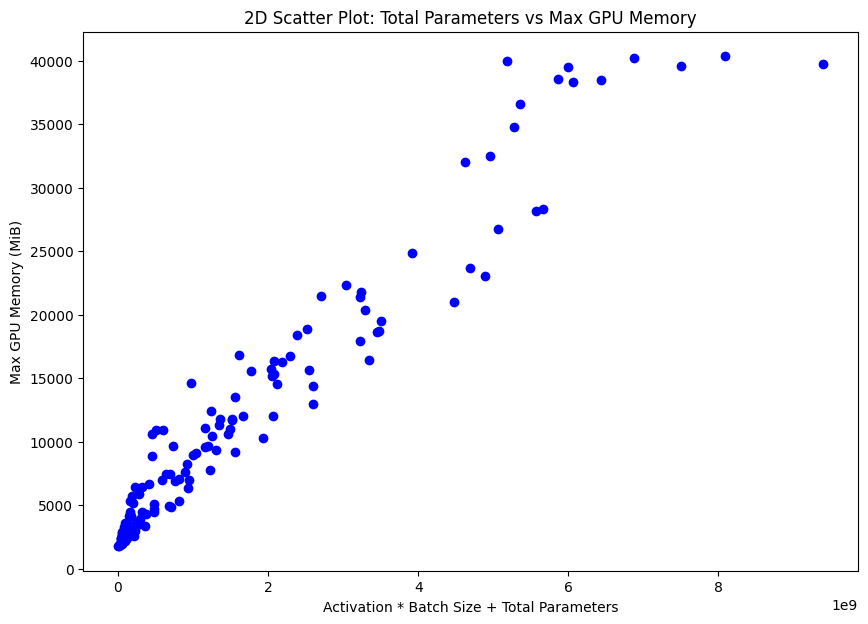

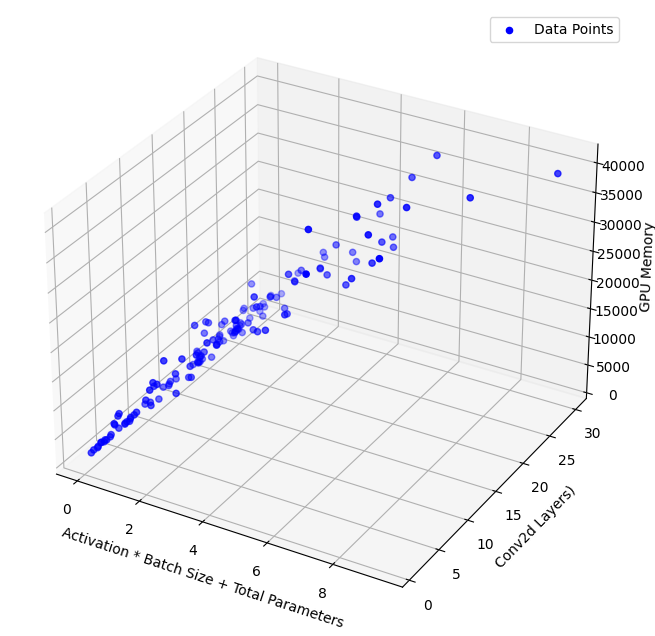

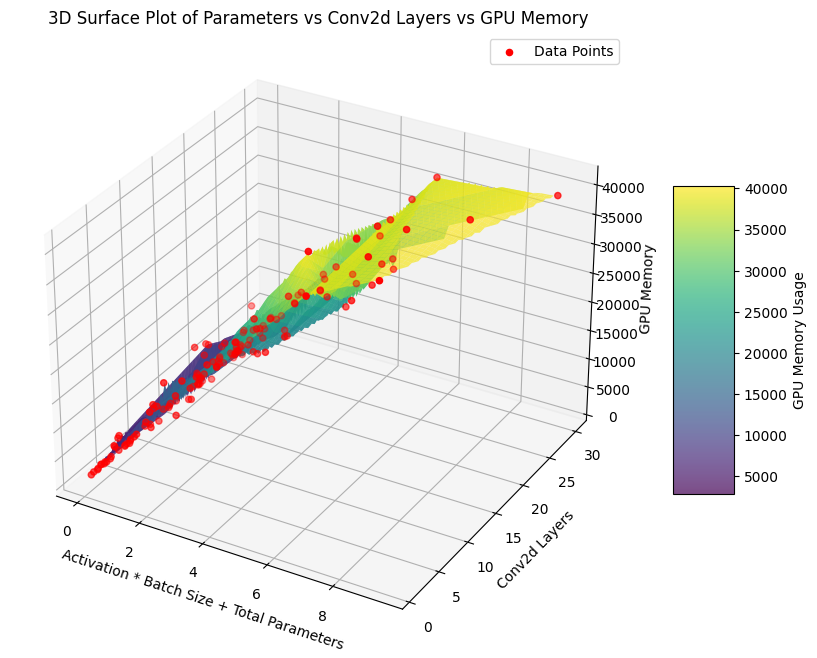

In [8]:
import matplotlib.pyplot as plt

df_tmp = df_tmp[df_tmp['BatchNorm2d Count'] == 0]
df_tmp = df_tmp[df_tmp['Dropout Count'] == 0]
df_tmp = df_tmp[df_tmp['Activation Function'] == "LeakyReLU"]

print(df_tmp)
# Prepare data for the 2D plot
# x = df_tmp['Total Parameters']
x = (df_tmp['Total Activations'] * df_tmp['Batch Size'] + df_tmp['Total Parameters'])
y = df_tmp['Conv2d Count']
z = df_tmp['Max GPU Memory (MiB)']

# Create a 2D scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(x, z, c='b', marker='o')

# Labels
plt.xlabel('Activation * Batch Size + Total Parameters')
plt.ylabel('Max GPU Memory (MiB)')
plt.title('2D Scatter Plot: Total Parameters vs Max GPU Memory')

plt.show()

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, c='b', marker='o', label='Data Points')

# Labels
ax.set_xlabel('Activation * Batch Size + Total Parameters')
ax.set_ylabel('Conv2d Layers)')
ax.set_zlabel('GPU Memory')

# Show legend
ax.legend()

# Display the plot
plt.show()

from scipy.interpolate import griddata

# Generate a grid for the surface using x and y data
x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))

# Interpolate the z values (GPU memory) over the grid
z_grid = griddata((x, y), z, (x_grid, y_grid), method='linear')

# Plotting the data with GPU memory usage as a surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='none', alpha=0.7)

# Scatter plot on top of the surface
ax.scatter(x, y, z, c='r', marker='o', label='Data Points')

# Labels
ax.set_xlabel('Activation * Batch Size + Total Parameters')
ax.set_ylabel('Conv2d Layers')
ax.set_zlabel('GPU Memory')
ax.set_title('3D Surface Plot of Parameters vs Conv2d Layers vs GPU Memory')

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('GPU Memory Usage')

# Show legend
ax.legend()

# Display the 3D surface plot
plt.show()

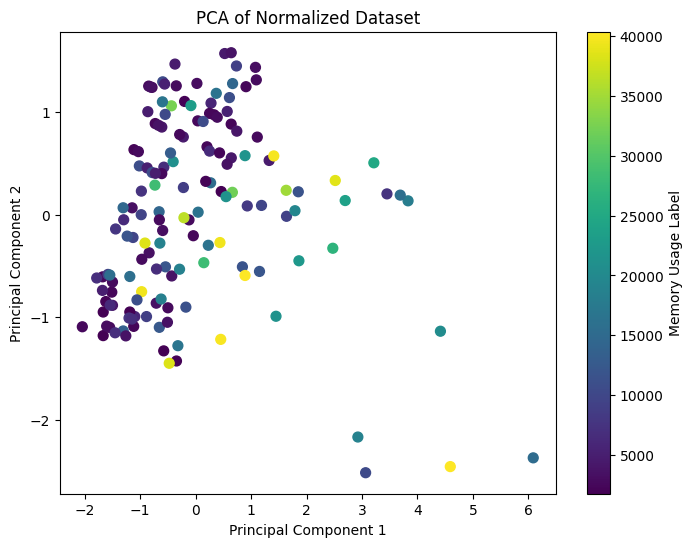

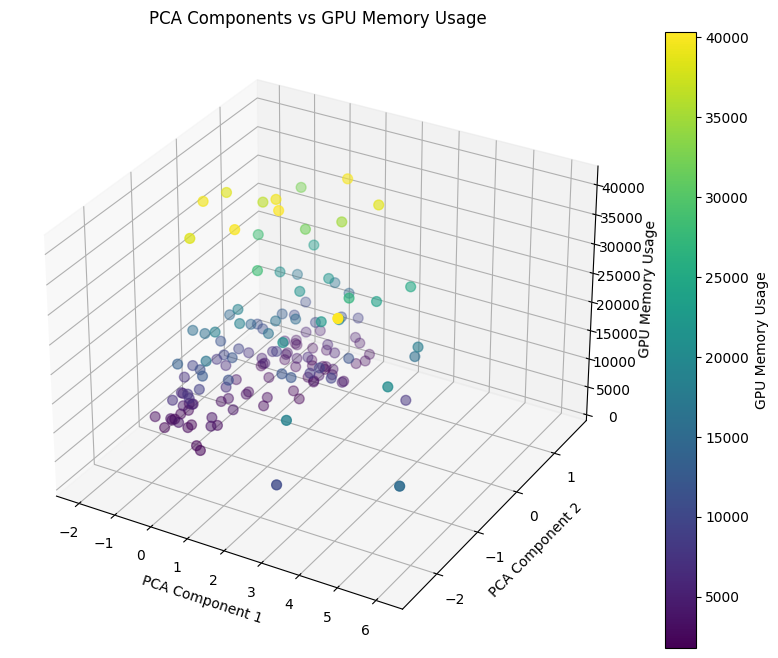

PCA Components:
[[ 0.52944758  0.54284576 -0.48854152  0.43166065 -0.         -0.        ]
 [-0.48466721 -0.10664684  0.11641387  0.86033247  0.          0.        ]]
Explained variance ratio:
[0.48806838 0.20153537]


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file


# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# X = df[['all_activations', 'all_parameters', 'batch_size', 'conv2d_layers', 'total_activation_mul_batch_size','batch_norm2d_layer', 'dropout_layers']]  # Input features
# X = df[['all_activations', 'all_parameters', 'batch_size', 'conv2d_layers', 'total_activation_mul_batch_size', 'batch_norm2d_layer']]  # Input features

# X = df_tmp[['Total Activations', 'Total Parameters', 'Batch Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count']]
X = df_tmp[['Total Activations', 'Total Parameters', 'Batch Size', 'Conv2d Count']]
y = df_tmp['Max GPU Memory (MiB)']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()


# Prepare data
X = df_tmp[['Total Activations', 'Total Parameters', 'Batch Size', 'Conv2d Count','BatchNorm2d Count', 'Dropout Count']]
y = df_tmp['Max GPU Memory (MiB)']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Plotting the PCA-reduced data with GPU memory usage as z-axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(pca1, pca2, y, c=y, cmap='viridis', s=50)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('PCA Components vs GPU Memory Usage')

# Color bar
cbar = plt.colorbar(scatter, ax=ax, label='GPU Memory Usage')
plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)

# One-hot coding for activations
Because this encoding increases the number of feature drastically is not a good way

In [ ]:
df_one_hot = pd.get_dummies(df['activation_function'], prefix='activation')

print(df_one_hot)


# saved_df = df

# Drop the original 'activation_function' column
# df = df.drop('activation_function', axis=1)

# # Concatenate the one-hot encoded columns back to the DataFrame
# df = pd.concat([df, df_one_hot], axis=1)

# print(df)

KeyError: 'activation_function'

In [ ]:
import numpy as np

# List of activation functions
activations = ['ELU', 'GELU', 'Identity', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        # Map i to a position on the unit circle
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate 2D positional encodings for the number of activations
num_activations = len(activations)
positional_encodings = positional_encoding_2d(num_activations)

# Create a dictionary mapping activations to their positional encodings
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Print the result
for activation, encoding in activation_to_encoding.items():
    print(f"{activation}: {encoding}")

ELU: [0. 1.]
GELU: [0.28173256 0.95949297]
Identity: [0.54064082 0.84125353]
LeakyReLU: [0.75574957 0.65486073]
Mish: [0.909632   0.41541501]
PReLU: [0.98982144 0.14231484]
ReLU: [ 0.98982144 -0.14231484]
SELU: [ 0.909632   -0.41541501]
SiLU: [ 0.75574957 -0.65486073]
Softplus: [ 0.54064082 -0.84125353]
Tanh: [ 0.28173256 -0.95949297]


# having activations functions as two separate columns

In [10]:
# List of activation functions
activations = ['ELU', 'GELU', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][1])

print(df.columns)


Index(['Activation Function', 'Total Activations', 'Total Parameters',
       'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count',
       'BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
       'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)',
       'activation_encoding_sin', 'activation_encoding_cos'],
      dtype='object')


In [11]:
df

,Activation Function,Total Activations,Total Parameters,Batch Size,Total_Activations_Batch_Size,Conv2d Count,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),Max GPU Memory (MiB),activation_encoding_sin,activation_encoding_cos
0,GELU,195826172,1864805,62,12141222664,22,0,22,1,1,21.70,123506.48,7.11,123535.29,39517,0.309017,9.510565e-01
1,SELU,306385536,32924348,46,14093734656,11,11,11,1,1,2.30,134408.32,125.60,134536.22,42000,0.951057,-3.090170e-01
2,ELU,27443119,1730036,34,933066046,14,0,0,1,1,3.06,10678.04,6.60,10687.70,6293,0.000000,1.000000e+00
3,ELU,119603463,731920,10,1196034630,16,16,16,1,1,2.90,11406.30,2.79,11411.99,6475,0.000000,1.000000e+00
4,ReLU,11111315,2960902,18,200003670,12,12,0,1,1,0.18,2034.54,11.29,2046.01,2779,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,ELU,1224102531,174087245,14,17137435434,21,21,21,1,1,2.66,163435.30,664.09,164102.05,42000,0.000000,1.000000e+00
8996,ELU,964897150,206115033,26,25087325900,21,0,21,1,1,4.68,255201.44,786.27,255992.39,42000,0.000000,1.000000e+00
8997,PReLU,273489723,250091310,22,6016773906,29,0,29,1,1,0.88,61205.76,954.02,62160.66,26097,0.951057,3.090170e-01
8998,PReLU,810435666,182544909,20,16208713320,19,19,0,1,1,3.40,164883.40,696.35,165583.15,42000,0.951057,3.090170e-01


# filter the data


In [12]:
class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the training loss and accuracy logged during the epoch
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())
        self.train_accuracies.append(trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the validation loss and accuracy logged during the epoch
        self.val_losses.append(trainer.callback_metrics["val_loss"].item())
        self.val_accuracies.append(trainer.callback_metrics["val_acc"].item())

    def plot_history(self):
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label="Training Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
# in case wanna filter some of the data use this code

# df_filtered = df[df['layers'] <= 64]
# df_filtered = df_filtered[df_filtered['all_parameters'] <= 10e6]
# df_filtered = df_filtered[df_filtered['batch_size'] <= 64]
# df_filtered = df_filtered[df_filtered['all_activations'] <= 1e5]
# print(len(df_filtered))
# plot_data_hist(df_filtered)


In [13]:
class FC_base(nn.Module):
    def __init__(self, input_features=8, output_features=5, base_features=6):
        super(FC_base, self).__init__()

        # Define the network architecture
        self.fc1 = nn.Linear(input_features, base_features)  # First layer (6 -> 64 units)
        self.bn1 = nn.BatchNorm1d(base_features)             # Batch Normalization after the first layer
        self.fc2 = nn.Linear(base_features, base_features)             # Second layer (64 -> 128 units)
        self.bn2 = nn.BatchNorm1d(base_features)            # Batch Normalization after the second layer
        self.fc3 = nn.Linear(base_features, base_features)             # Third layer (128 -> 64 units)
        self.bn3 = nn.BatchNorm1d(base_features)             # Batch Normalization after the third layer
        self.fc4 = nn.Linear(base_features, base_features)             # Third layer (128 -> 64 units)
        self.bn4 = nn.BatchNorm1d(base_features)
        self.fc5 = nn.Linear(base_features, output_features) # Output layer (64 -> 1 output for regression)
        self.dropout = nn.Dropout(p=0.0)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        # Forward pass through the network
        x = self.relu(self.bn1(self.fc1(x)))
        # print(f"After fc1 shape: {x.shape}")
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        # print(f"After fc2 shape: {x.shape}")
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        # print(f"After fc3 shape: {x.shape}")
        # x = self.dropout(self.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)  # No activation function for the output layer in regression
        # print(f"Output shape: {x.shape}")
        return x

# classification

     Activation Function
0                   GELU
1                   SELU
2                    ELU
3                    ELU
4                   ReLU
...                  ...
8995                 ELU
8996                 ELU
8997               PReLU
8998               PReLU
8999                ReLU

[8814 rows x 1 columns]
Index(['Activation Function', 'Total Activations', 'Total Parameters',
       'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count',
       'BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
       'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)',
       'activation_encoding_sin', 'activation_encoding_cos'],
      dtype='object')


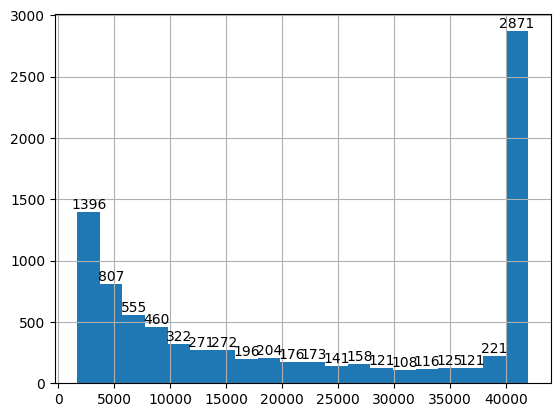

In [14]:
columns_to_normalize = ['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']



from sklearn.preprocessing import StandardScaler
# # Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)

# no normalization
# df_normalized = df

print(df[["Activation Function"]])

print(df.columns)

df['Max GPU Memory (MiB)'].hist(bins=20)

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

# Hard Labeling

In [15]:
import pandas as pd

# Define bins where values between 0-10000 fall into class 0, 10000-20000 into class 1, and so on
# bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, float('inf')]

bins = [i*2000 for i in range(0, 23)]
# Define labels corresponding to the bins
labels = [i for i in range(len(bins) - 1)]


print(labels, "\n", bins)

# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['Max GPU Memory (MiB)'], bins=bins, labels=labels, right=False)

# Display some rows where 'memory_usage_label' falls into the last bin (infinite)
inf_rows = df.loc[df['memory_usage_label'] == labels[-1]]  # labels[-1] is the label for the last bin
print(inf_rows.head())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] 
 [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 40000, 42000, 44000]
   Activation Function  Total Activations  Total Parameters  Batch Size  \
1                 SELU          306385536          32924348          46   
12               PReLU          603033793          38204027          32   
14           LeakyReLU         2342035538         142278957          28   
16                GELU          352511430          10174557          56   
39           LeakyReLU         1169505752         115743545          50   

    Total_Activations_Batch_Size  Conv2d Count  BatchNorm2d Count  \
1                    14093734656            11                 11   
12                   19297081376            13                 13   
14                   65576995064            27                 27   
16                   19740640080      

In [ ]:
unique_values = df['memory_usage_label'].unique()

# Print the unique values
print(unique_values)

[19, 21, 3, 1, 2, ..., 15, 12, 9, 13, 20]
Length: 22
Categories (22, int64): [0 < 1 < 2 < 3 ... 18 < 19 < 20 < 21]


# Soft Labeling

In [16]:
def smooth_labels(labels, num_classes, smoothing=0.1):
    """
    Apply label smoothing to the given labels.

    Args:
        labels (torch.Tensor): The hard labels to smooth.
        num_classes (int): Total number of classes.
        smoothing (float): Smoothing factor (0 means no smoothing).

    Returns:
        torch.Tensor: Smoothed labels.
    """
    confidence = 1.0 - smoothing
    # Create a tensor of smoothed labels of size (batch_size, num_classes)
    smoothed_labels = torch.full(size=(labels.size(0), num_classes), fill_value=smoothing / (num_classes - 1),
                                 device=labels.device)
    smoothed_labels.scatter_(1, labels.data.unsqueeze(1), confidence)
    return smoothed_labels

In [17]:
# Assuming 'df' is your DataFrame and you have labeled it with the memory usage labels as shown
# Convert labels to a tensor
labels_tensor = torch.tensor(df['memory_usage_label'].values, dtype=torch.long)

# Define the number of classes (in this case, 5 bins)
num_classes = len(labels)

# Apply soft labeling
smoothing = 0.1  # Adjust the smoothing factor as needed
smoothed_labels = smooth_labels(labels_tensor, num_classes, smoothing)

# Now you can use 'smoothed_labels' in your training loop

In [18]:
df

,Activation Function,Total Activations,Total Parameters,Batch Size,Total_Activations_Batch_Size,Conv2d Count,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),Max GPU Memory (MiB),activation_encoding_sin,activation_encoding_cos,memory_usage_label
0,GELU,195826172,1864805,62,12141222664,22,0,22,1,1,21.70,123506.48,7.11,123535.29,39517,0.309017,9.510565e-01,19
1,SELU,306385536,32924348,46,14093734656,11,11,11,1,1,2.30,134408.32,125.60,134536.22,42000,0.951057,-3.090170e-01,21
2,ELU,27443119,1730036,34,933066046,14,0,0,1,1,3.06,10678.04,6.60,10687.70,6293,0.000000,1.000000e+00,3
3,ELU,119603463,731920,10,1196034630,16,16,16,1,1,2.90,11406.30,2.79,11411.99,6475,0.000000,1.000000e+00,3
4,ReLU,11111315,2960902,18,200003670,12,12,0,1,1,0.18,2034.54,11.29,2046.01,2779,1.000000,6.123234e-17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,ELU,1224102531,174087245,14,17137435434,21,21,21,1,1,2.66,163435.30,664.09,164102.05,42000,0.000000,1.000000e+00,21
8996,ELU,964897150,206115033,26,25087325900,21,0,21,1,1,4.68,255201.44,786.27,255992.39,42000,0.000000,1.000000e+00,21
8997,PReLU,273489723,250091310,22,6016773906,29,0,29,1,1,0.88,61205.76,954.02,62160.66,26097,0.951057,3.090170e-01,13
8998,PReLU,810435666,182544909,20,16208713320,19,19,0,1,1,3.40,164883.40,696.35,165583.15,42000,0.951057,3.090170e-01,21


In [19]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df_normalized[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df_normalized))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

total data size:  8814
train size 6169, val size: 1746, test size: 899


In [20]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        # Store the input and target data
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        # Returns the total number of samples
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a single sample (input, target pair)
        return self.inputs[idx], self.targets[idx]

train_dataloader = DataLoader(CustomDataset(x_train, y_train), 64, num_workers=2, shuffle=True)
val_dataloader = DataLoader(CustomDataset(x_val, y_val), 64, num_workers=2)
test_dataloader = DataLoader(CustomDataset(x_test, y_test),1, num_workers=1)
x, y = next(iter(train_dataloader))
print(f"input shape: {x.shape}, output shape: {y.shape}")

input shape: torch.Size([64, 13]), output shape: torch.Size([64])


# lable Smoothening loss

In [21]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, predictions, target):
        num_classes = predictions.size(1)
        smoothed_labels = smooth_labels(target, num_classes, self.smoothing)
        log_probs = torch.log_softmax(predictions, dim=-1)
        loss = -torch.mean(torch.sum(smoothed_labels * log_probs, dim=-1))
        return loss

# Example usage in training loop
criterion = LabelSmoothingLoss(smoothing=0.1)

In [22]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=13, output_features=output_size, base_features=12)
        # self.criterion = nn.MSELoss()
        # self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()
        self.criterion = LabelSmoothingLoss(smoothing=smoothing)
        self.output_size = output_size
        self.smoothing = smoothing


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()

        # Apply label smoothing to the target labels
        smoothed_labels = smooth_labels(y, self.output_size, self.smoothing)

        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        self.log('train_acc', acc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('val_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, on_step=False, prog_bar=True)

        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = Adam(self.parameters(), lr=0.0001)

        # # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         'monitor': 'val_loss',
        #         'frequency': 1
        #     }
        # }
        return optimizer

In [23]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')
# logger = TensorBoardLogger("logs")
# Create a checkpoint callback

# checkpoint_callback = ModelCheckpoint(
#     dirpath=config['model_save_dir'],
#     filename=f"{config['modality_type']}",
#     save_top_k=1,
#     verbose=True,
#     monitor='val_loss',
#     mode='min'
# )

# Initialize the model
classifier_model = classification_gpu_usage(output_size = len(labels))

classifier_model = classification_gpu_usage(output_size = len(labels)).to(device)

summary(classifier_model, input_size=(13,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             168
       BatchNorm1d-2                   [-1, 12]              24
              ReLU-3                   [-1, 12]               0
            Linear-4                   [-1, 12]             156
       BatchNorm1d-5                   [-1, 12]              24
              ReLU-6                   [-1, 12]               0
           Dropout-7                   [-1, 12]               0
            Linear-8                   [-1, 12]             156
       BatchNorm1d-9                   [-1, 12]              24
             ReLU-10                   [-1, 12]               0
          Dropout-11                   [-1, 12]               0
           Linear-12                   [-1, 22]             286
          FC_base-13                   [-1, 22]               0
Total params: 838
Trainable params: 838

In [24]:
# Initialize the history callback
history_callback = HistoryCallback()

classifier_model.train()
# Initialize the trainer with mixed precision (AMP) and early stopping
trainer = pl.Trainer(
    # logger = logger,
    max_epochs=200,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping, history_callback],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | FC_base            | 1.0 K  | train
1 | criterion | LabelSmoothingLoss | 0      | train
---------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 3.041


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 2.985


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 2.936


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 2.879


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 2.825


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 2.776


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 2.714


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 2.668


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 2.614


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 2.558


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 2.511


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 2.459


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.436


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 2.383


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 2.347


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 2.306


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 2.295


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 2.249


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 2.230


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 2.206


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 2.182


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 2.156


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 2.137


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 2.136


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 2.107


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 2.089


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 2.081


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 2.077


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 2.065


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 2.063


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 2.041


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 2.036


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 2.028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 2.011


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 2.002


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.998


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.996


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.975


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.965


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.959


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.953


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.952


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.945


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.931


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.924


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.905


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.899


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.897


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.896


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.888


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.887


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.885


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.865


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.851


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.848


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.826


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.817


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.817


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.806


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.798


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.786


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.764


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 20 records. Best score: 1.764. Signaling Trainer to stop.


In [25]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0])
        if test_data[1].item() != torch.argmax(pred, 1).item():
            print(f"prediction: {torch.softmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

prediction: tensor([[0.0028, 0.0046, 0.0033, 0.0057, 0.0118, 0.0134, 0.0200, 0.0240, 0.0413,
         0.0475, 0.0493, 0.0598, 0.0592, 0.0823, 0.0586, 0.0760, 0.0717, 0.0542,
         0.0766, 0.1062, 0.0276, 0.1043]]), ground truth: tensor([14.])
prediction: tensor([[0.0006, 0.0081, 0.0244, 0.0479, 0.0910, 0.0973, 0.1032, 0.1279, 0.0902,
         0.0983, 0.0750, 0.0533, 0.0408, 0.0353, 0.0208, 0.0181, 0.0164, 0.0176,
         0.0111, 0.0106, 0.0059, 0.0062]]), ground truth: tensor([5.])
prediction: tensor([[0.0003, 0.0026, 0.0051, 0.0129, 0.0304, 0.0363, 0.0652, 0.0608, 0.0925,
         0.0900, 0.0872, 0.1101, 0.0638, 0.0917, 0.0469, 0.0427, 0.0428, 0.0329,
         0.0297, 0.0329, 0.0102, 0.0130]]), ground truth: tensor([7.])
prediction: tensor([[0.0013, 0.0050, 0.0079, 0.0163, 0.0376, 0.0359, 0.0554, 0.0527, 0.0949,
         0.0810, 0.0814, 0.0980, 0.0610, 0.1062, 0.0420, 0.0423, 0.0486, 0.0376,
         0.0325, 0.0303, 0.0130, 0.0193]]), ground truth: tensor([9.])
prediction: tensor(

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.5395
Precision: 0.4715
Recall: 0.5395
F1-Score: 0.4884

Confusion Matrix:
[[  0  42   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0  78  35   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   7  32   9  22   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   2   9   7  44   6   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   1  25   2   0   2   1   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   1   0  17   3   2   6   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   6   3   0  11   0   1   1   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   3   2   4   9   0   1   2   0   0   1   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   2   1   0  11   0   0   2   1   0   2   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   1   0   3  11   0   0   3   1   0   1   0   0   0   0
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
from sklearn.manifold import TSNE

print(df.columns)

# Initialize the t-SNE model
tsne = TSNE(n_components=2, random_state=43)

# Fit and transform the features

# tsne_results = tsne.fit_transform(df[['all_activations', 'all_parameters', 'batch_size','total_activation_mul_batch_size', 'conv2d_layers','batch_norm2d_layer', 'dropout_layers']])
# tsne_results = tsne.fit_transform(df[['all_activations', 'all_parameters', 'batch_size','total_activation_mul_batch_size', 'conv2d_layers','batch_norm2d_layer']])

tsne_results = tsne.fit_transform(df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']])

Index(['Activation Function', 'Total Activations', 'Total Parameters',
       'Batch Size', 'Total_Activations_Batch_Size', 'Conv2d Count',
       'BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
       'Linear Count', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)', 'Max GPU Memory (MiB)',
       'activation_encoding_sin', 'activation_encoding_cos',
       'memory_usage_label'],
      dtype='object')


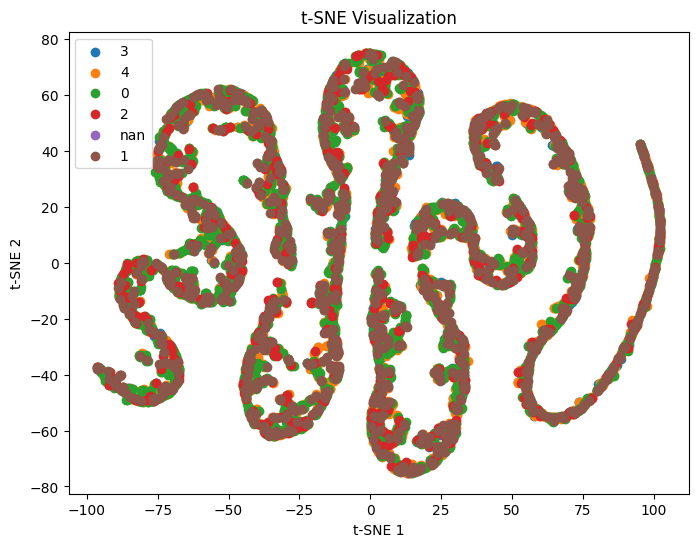

In [ ]:
import matplotlib.pyplot as plt

# Create a new DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['label'] = df['memory_usage_label']

# Plot the results
plt.figure(figsize=(8, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['tsne1'], subset['tsne2'], label=label)

plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Initialize the t-SNE model with 3 components
tsne = TSNE(n_components=3, random_state=43)


# Fit and transform the features

tsne_results = tsne.fit_transform(df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']])

# Create a new DataFrame for the t-SNE results (3 components)
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2', 'tsne3'])
tsne_df['label'] = df['memory_usage_label']

# Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    ax.scatter(subset['tsne1'], subset['tsne2'], subset['tsne3'], label=label)

# Set plot title and labels
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

# Add legend
plt.legend()

# Show the plot
plt.show()

# PCA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()

components = pca.components_

# Get the explained variance ratio for each component (optional, to know how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Show the components (each row corresponds to a principal component, each column corresponds to the original feature)
print("PCA Components:")
print(components)

# Show the explained variance ratio for each component
print("Explained variance ratio:")
print(explained_variance)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file


# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# X = df[['all_activations', 'all_parameters', 'batch_size', 'conv2d_layers','batch_norm2d_layer', 'dropout_layers']]  # Input features
X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()

components = pca.components_

# Get the explained variance ratio for each component (optional, to know how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Show the components (each row corresponds to a principal component, each column corresponds to the original feature)
print("PCA Components:")
print(components)

# Show the explained variance ratio for each component
print("Explained variance ratio:")
print(explained_variance)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=3)  # Change to 3 components for 3D plotting
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], y, c=y, cmap='viridis', s=50, alpha=0.7)

# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Memory Usage Label')
ax.set_title('3D PCA of Normalized Dataset')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Memory Usage Label')

# Show the plot
plt.show()

# Retrieve and display PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained Variance Ratio:")
print(explained_variance)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Plotting the PCA-reduced data with GPU memory usage as z-axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(pca1, pca2, y, c=y, cmap='viridis', s=50)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('PCA Components vs GPU Memory Usage')

# Color bar
cbar = plt.colorbar(scatter, ax=ax, label='GPU Memory Usage')
plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']]
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Create grid for surface plot
pca1_grid, pca2_grid = np.meshgrid(np.linspace(pca1.min(), pca1.max(), 100),
                                   np.linspace(pca2.min(), pca2.max(), 100))

# Interpolate to fit the GPU memory usage on the grid
memory_usage_grid = griddata((pca1, pca2), y, (pca1_grid, pca2_grid), method='linear')

# Plotting the PCA-reduced data with GPU memory usage as a surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(pca1_grid, pca2_grid, memory_usage_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('Surface Plot of PCA Components vs GPU Memory Usage')

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('GPU Memory Usage')

plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)

# regression model

In [ ]:
columns_to_normalize = ['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
df_normalized_reg = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)

# no normalization
# df_normalized = df

In [ ]:
from sklearn.model_selection import train_test_split
x_train_reg, x_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    df_normalized_reg[['layers', 'batch_size', 'all_parameters', 'all_activations']].values, df_normalized_reg['real_memory_usage'].values, test_size=0.3, random_state=42)

x_test_reg, x_val_reg, y_test_reg, y_val_reg = train_test_split(
    x_temp_reg, y_temp_reg, test_size=0.66, random_state=42)

print('total data size: ', len(df_normalized))
print(f"train size {len(x_train_reg)}, val size: {len(x_val_reg)}, test size: {len(x_test_reg)}")

In [ ]:
train_dataloader_reg = DataLoader(CustomDataset(x_train_reg, y_train_reg), 64, num_workers=2, shuffle=True)
val_dataloader_reg = DataLoader(CustomDataset(x_val_reg, y_val_reg), 64, num_workers=2)
test_dataloader_reg = DataLoader(CustomDataset(x_test_reg, y_test_reg),1, num_workers=1)
x, y = next(iter(train_dataloader_reg))
print(f"input shape: {x.shape}, output shape: {y.shape}")

In [ ]:
class regression_gpu_usage(pl.LightningModule):
    def __init__(self):
        super(regression_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=4, output_features=1, base_features=4)
        # self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()
        # self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = Adam(self.parameters(), lr=0.0001)

        # # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         'monitor': 'val_loss',
        #         'frequency': 1
        #     }
        # }
        return optimizer



In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
# logger = TensorBoardLogger("logs")
# Create a checkpoint callback

# checkpoint_callback = ModelCheckpoint(
#     dirpath=config['model_save_dir'],
#     filename=f"{config['modality_type']}",
#     save_top_k=1,
#     verbose=True,
#     monitor='val_loss',
#     mode='min'
# )

# Initialize the model
regression_model = regression_gpu_usage()
regression_model.train()
# Initialize the trainer with mixed precision (AMP) and early stopping
trainer = pl.Trainer(
    # logger = logger,
    max_epochs=200,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(regression_model, train_dataloaders=train_dataloader_reg, val_dataloaders=val_dataloader_reg)



In [ ]:
regression_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader_reg:
        pred = regression_model(test_data[0])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(pred.item())
        print(f"prediction: {pred.item()}, gt: {test_data[1].item()}")

plt.figure(figsize=(15, 3))
plt.scatter(range(1, len(pred_list) + 1), pred_list, label="predicted")
plt.scatter(range(1, len(gt) + 1), gt, label="actual value")
plt.legend()